In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="ticks")
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
%matplotlib inline
from scipy.optimize import curve_fit 
from scipy import stats
import datetime as dt
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import pickle
from sklearn.model_selection import train_test_split

In [2]:
# Read from the exisiting cleaned pkl file
#df_main = pd.read_pickle('/scratch/d.dasarathan/df_newdata_cleaned_added_features_sbatch.pkl')
#df_main = pd.read_pickle('/scratch/d.dasarathan/df_newdata_cleaned_100k_added_features.pkl')
df_main = pd.read_pickle('/scratch/d.dasarathan/df_newdata_cleaned_500k_added_features.pkl')
#df_main = pd.read_pickle('/scratch/d.dasarathan/df_newdata_cleaned_600k_added_features.pkl')
df_main.head()

,Account,AdminComment,AllocCPUS,AllocGRES,AllocNodes,AllocTRES,AssocID,AveCPU,AveCPUFreq,AveDiskRead,AveDiskWrite,AvePages,AveRSS,AveVMSize,BlockID,Cluster,Comment,ConsumedEnergy,ConsumedEnergyRaw,CPUTime,CPUTimeRAW,DerivedExitCode,Elapsed,ElapsedRaw,Eligible,End,ExitCode,GID,Group,JobID,JobIDRaw,JobName,Layout,MaxDiskRead,MaxDiskReadNode,MaxDiskReadTask,MaxDiskWrite,MaxDiskWriteNode,MaxDiskWriteTask,MaxPages,MaxPagesNode,MaxPagesTask,MaxRSS,MaxRSSNode,MaxRSSTask,MaxVMSize,MaxVMSizeNode,MaxVMSizeTask,McsLabel,MinCPU,MinCPUNode,MinCPUTask,NCPUS,NNodes,NodeList,NTasks,Priority,Partition,QOS,QOSRAW,ReqCPUFreq,ReqCPUFreqMin,ReqCPUFreqMax,ReqCPUFreqGov,ReqCPUS,ReqGRES,ReqNodes,ReqTRES,Reservation,ReservationId,Reserved,ResvCPU,ResvCPURAW,Start,State,Submit,Suspended,SystemCPU,TotalCPU,UID,User,UserCPU,WCKey,WCKeyID,WorkDir,Unnamed: 87,waitTime,waitTimeHr,Req_totalMem,Timelimit_hr,QOD,QOY,exclusive,corehrs,rnjbct
0,steven.lopez,NaN,7.0,NaN,1.0,"cpu=7,mem=55G,node=1,billing=7",5187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discovery,NaN,0.0,0.0,00:40:36,2436.0,0:0,00:05:48,348,2020-05-17 15:35:54,2020-05-17 16:01:36,0:0,100.0,users,11602102_128,11602922,cp-4e4r-ORCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1.0,d3004,NaN,16007.0,lopez,normal,1.0,Unknown,Unknown,Unknown,Unknown,7,NaN,1,"cpu=7,mem=55G,node=1",NaN,NaN,00:19:54,02:19:18,8358.0,2020-05-17 15:55:48,COMPLETED,2020-05-17 15:35:52,00:00:00,00:09.466,29:29.533,1.825619e+09,steinr,29:20.066,NaN,0.0,/scratch/steinr/ORCA/tod/opt/cp-4e4r/CREST,NaN,0 days 00:19:56,0.332222,55.0,24.0,q3,q2,0,168.0,77
1,lotterhos,NaN,1.0,NaN,1.0,"cpu=1,mem=50G,node=1,billing=1",4488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discovery,NaN,0.0,0.0,00:01:35,95.0,0:0,00:01:35,95,2020-08-13 17:14:24,2020-08-13 17:21:38,0:0,100.0,users,13253497,13253497,3383.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,c0198,NaN,17612.0,express,normal,1.0,Unknown,Unknown,Unknown,Unknown,1,NaN,10,"cpu=1,mem=50G,node=1",NaN,NaN,00:05:39,00:05:39,339.0,2020-08-13 17:20:03,COMPLETED,2020-08-13 17:14:24,00:00:00,00:00.540,01:34.502,1.825568e+09,albecker,01:33.961,NaN,0.0,/scratch/albecker/Power_analysis,NaN,0 days 00:05:39,0.094167,500.0,1.0,q3,q3,0,1.0,151
2,dapeng,NaN,28.0,NaN,1.0,"cpu=28,mem=200G,node=1,billing=28",5831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discovery,NaN,0.0,0.0,00:22:52,1372.0,0:0,00:00:49,49,2020-09-08 00:40:55,2020-09-08 00:41:58,0:0,100.0,users,13946485,13946485,short_22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,1.0,c0476,NaN,15077.0,short,normal,1.0,Unknown,Unknown,Unknown,Unknown,28,NaN,1,"cpu=28,mem=200G,node=1",NaN,NaN,00:00:14,00:06:32,392.0,2020-09-08 00:41:09,COMPLETED,2020-09-08 00:40:55,00:00:00,00:02.827,00:18.500,1.825455e+09,huang.junx,00:15.673,NaN,0.0,/scratch/jxh,NaN,0 days 00:00:14,0.003889,200.0,24.0,q1,q3,0,672.0,82
3,steven.lopez,NaN,1.0,NaN,1.0,"cpu=1,mem=3G,node=1,billing=1",4525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discovery,NaN,0.0,0.0,00:07:29,449.0,0:0,00:07:29,449,2020-08-06 17:10:51,2020-08-06 17:31:15,0:0,100.0,users,13030602,13030602,2bt-83-81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,c0308,NaN,15738.0,short,normal,1.0,Unknown,Unknown,Unknown,Unknown,1,NaN,10,"cpu=1,mem=3G,node=1",NaN,NaN,00:12:55,00:12:55,775.0,2020-08-06 17:23:46,COMPLETED,2020-08-06 17:10:51,00:00:00,00:59.926,07:19.510,1.825607e+09,lijingbai2009,06:19.584,NaN,0.0,/scratch/lijingbai2009/NN-PES-QD/training-data...,NaN,0 days 00:12:55,0.215278,30.0,10.0,q3,q3,0,10.0,64
4,netsi,NaN,1.0,NaN,1.0,"cpu=1,mem=200G,node=1,billing=1",5217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discovery,NaN,0.0,0.0,00:00:03,3.0,0:0,00:00:03,3,2020-09-11 19:11:53,2020-09-13 02:21:24,1:0,100.0,users,14255256,14255256,un_eval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,c3201,NaN,16757.0,netsi_standard,normal,1.0,Unknown,Unknown,Unknown,Unknown,1,NaN,1,"cpu=1,me

In [32]:
df=df_main[['ReqNodes', 'Priority', 'Partition', 'waitTimeHr', 'Req_totalMem', 'corehrs', 'QOD', 'QOY','exclusive','rnjbct']]
df

,ReqNodes,Priority,Partition,waitTimeHr,Req_totalMem,corehrs,QOD,QOY,exclusive,rnjbct
0,1,16007.0,lopez,0.332222,55.000000,168.0,q3,q2,0,77
1,10,17612.0,express,0.094167,500.000000,1.0,q3,q3,0,151
2,1,15077.0,short,0.003889,200.000000,672.0,q1,q3,0,82
3,10,15738.0,short,0.215278,30.000000,10.0,q3,q3,0,64
4,1,16757.0,netsi_standard,31.157778,200.000000,120.0,q4,q3,0,58
...,...,...,...,...,...,...,...,...,...,...
499993,1,90.0,maloney,0.079167,1.953125,8760.0,q4,q3,0,88
499994,1,14796.0,west,0.024722,5.000000,2400.0,q4,q4,0,67
499995,2,13890.0,large,0.018333,109.375000,336.0,q2,q4,0,29
499996,1,15134.0,short,0.003889,200.000000,672.0,q4,q3,0,127


In [33]:
# Resample/Shuffle the data
df=df.sample(frac=1).reset_index(drop=True)
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499998 entries, 0 to 499997
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ReqNodes      499998 non-null  int64  
 1   Priority      499998 non-null  float64
 2   Partition     499998 non-null  object 
 3   waitTimeHr    499998 non-null  float64
 4   Req_totalMem  499998 non-null  float64
 5   corehrs       499998 non-null  float64
 6   QOD           499998 non-null  object 
 7   QOY           499998 non-null  object 
 8   exclusive     499998 non-null  int64  
 9   rnjbct        499998 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 38.1+ MB


In [30]:
# One-hot encode categorical columns
df=pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499998 entries, 0 to 499997
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ReqNodes                  499998 non-null  int64  
 1   Priority                  499998 non-null  float64
 2   waitTimeHr                499998 non-null  float64
 3   Req_totalMem              499998 non-null  float64
 4   corehrs                   499998 non-null  float64
 5   exclusive                 499998 non-null  int64  
 6   rnjbct                    499998 non-null  int64  
 7   Partition_allshouse       499998 non-null  uint8  
 8   Partition_bansil          499998 non-null  uint8  
 9   Partition_chen            499998 non-null  uint8  
 10  Partition_danabrooks      499998 non-null  uint8  
 11  Partition_debug           499998 non-null  uint8  
 12  Partition_diomedes        499998 non-null  uint8  
 13  Partition_express         499998 non-null  u

In [6]:
# Remove outliers and take 95% of the data. 5% of the data goes away as outliers
#df = df[df['waitTimeHr'].between(df['waitTimeHr'].quantile(.0), df['waitTimeHr'].quantile(.95))]

In [7]:
# Assign the full data set to predictors df
#predictors = df
# Target is the value we want to predict
target = np.array(df['waitTimeHr'])

# Remove the target from the predictors
X = df.drop('waitTimeHr', axis = 1)

# Saving feature names for later use
feature_list = list(X.columns)

# Convert to numpy array
X = np.array(X)

In [8]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size = 0.20, random_state = 42)

In [9]:
print('x_train Shape:', x_train.shape)
print('y_train Shape:', y_train.shape)
print('x_test Shape:', x_test.shape)
print('y_test Shape:', y_test.shape)

x_train Shape: (399998, 54)
y_train Shape: (399998,)
x_test Shape: (100000, 54)
y_test Shape: (100000,)


In [10]:
%%time
# Instantiate model 
# Also, check how much time does it take for rf to fit the dataset to the model
# The n_jobs parameter is used to specify how many concurrent processes or threads should be used for routines that are parallelized with joblib.If set to -1, all CPUs are used. 

rf = RandomForestRegressor(n_estimators = 400, 
                           min_samples_split = 5, 
                           min_samples_leaf = 10, 
                           max_features = 'auto', 
                           max_depth = 50, 
                           bootstrap = False, 
                           n_jobs = -1)

#rf = RandomForestRegressor(n_estimators = 100, warm_start = True, min_samples_split = 5, min_samples_leaf = 10, max_features = 'auto', max_depth = 50, bootstrap = False, n_jobs = -1)

# Train the model on training data
rf.fit(x_train, y_train);

CPU times: user 20min 26s, sys: 715 ms, total: 20min 27s
Wall time: 20min 28s


RandomForestRegressor(bootstrap=False, max_depth=50, min_samples_leaf=10,
                      min_samples_split=5, n_estimators=400, n_jobs=-1)

In [11]:
#print("Train shape: ",train_predictors.shape)
#print("Training model iteratively")
#i=0
#for train_x_subset,train_y_subset in zip (np.vsplit(train_predictors,27),np.split(train_target,27)):
#    i+=1
#    print('Iteration no: ',i)
#    print("train_x_subset_shape: ",train_x_subset.shape)
#    print("train_y_subset_shape: ",train_y_subset.shape)
#    rf.fit(train_x_subset, train_y_subset);
#    rf.n_estimators += 20
#    print('*********************************')

In [14]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = feature_list,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
Priority,2.703193e-01
corehrs,1.714640e-01
rnjbct,1.690797e-01
Req_totalMem,9.455741e-02
exclusive,5.215107e-02
QOY_q2,3.696810e-02
QOY_q3,3.079176e-02
QOD_q4,3.032882e-02
ReqNodes,2.996075e-02
QOD_q2,1.945013e-02


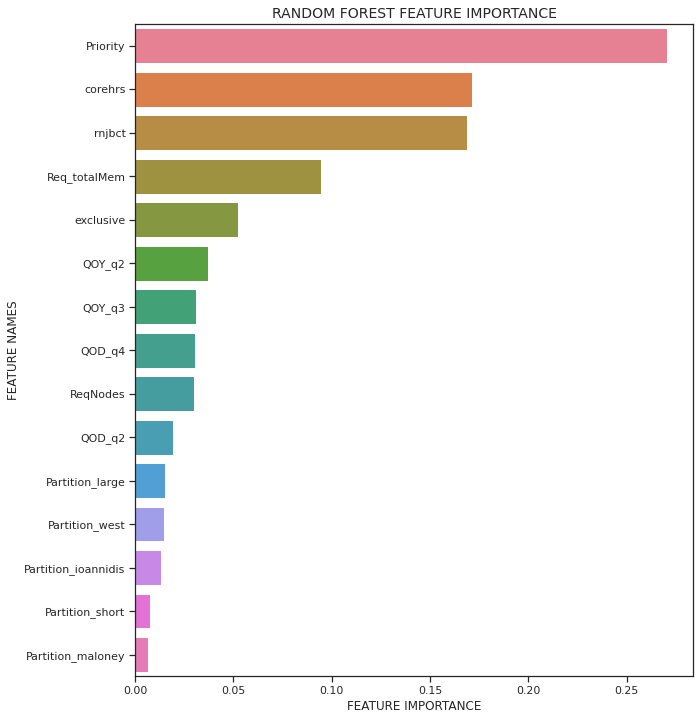

In [15]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in decreasing order of feature importance
    fi_df=fi_df.sort_values(by=['feature_importance'], ascending=False).head(15)
    
    #Define size of bar plot
    plt.figure(figsize=(10,12))
    #Plot Searborn bar chart
    splot=sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="husl")

    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE', size=14)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('/home/d.dasarathan/project_sml/100Kdataset/plots/FeaImpRadnForst.png')

plot_feature_importance(rf.feature_importances_,feature_list,'RANDOM FOREST')

In [16]:
print('R^2 Training Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(x_train, y_train),
                                                                         rf.score(x_test, y_test)))

R^2 Training Score: 0.74 
R^2 Test Score: 0.66


In [17]:
# Create a filename in which the trained model will be stored
rfFile = "/home/d.dasarathan/project_sml/100Kdataset/trainedbasicRF_08_16.pkl"

In [18]:
# Save the trained model to disk
pickle.dump(rf, open(rfFile, 'wb'))

In [19]:
# Use the forest's predict method on the test data
preds = rf.predict(x_test)

# Calculate the absolute errors
errors = abs(y_test - preds)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'wait hours.')

Mean Absolute Error: 1.71 wait hours.


### Hyperparameter Tuning Using Random Search

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 185, 321, 457, 592, 728, 864, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 21, 27, 32, 38, 44, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [22]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=38, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=592; total time= 2.6min
[CV] END bootstrap=True, max_depth=38, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=592; total time= 2.5min
[CV] END bootstrap=True, max_depth=38, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=592; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=864; total time= 3.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=864; total time= 3.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=864; total time= 3.8min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 21, 27, 32, 38,
                                                      44, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 185, 321, 457, 592,
                                                         728, 864, 1000]},
                   random_state=42, verbose=2)

In [23]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [24]:
rf = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 50, bootstrap = True, n_jobs = -1)
rf.fit(x_train, y_train);

In [25]:
preds = rf.predict(x_test)

# Calculate the absolute errors
errors = abs(y_test - preds)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'wait hours.')

Mean Absolute Error: 1.3 wait hours.


In [26]:
print('R^2 Training Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(x_train, y_train),
                                                                         rf.score(x_test, y_test)))

R^2 Training Score: 0.90 
R^2 Test Score: 0.77


#### Perform a 10 fold cross validation to check over/under fitting.

In [ ]:
for i, score in enumerate(cross_validate(rf, X, target, cv=10)["test_score"]):
    print(f"Accuracy for the fold no. {i } on the test set: {score}")

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 27, alpha = 10, n_estimators = 400)

In [ ]:
xg_reg.fit(x_train, y_train)
preds = xg_reg.predict(x_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
# Calculate the absolute errors
errors = abs(y_test - preds)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'wait hours.')

In [ ]:
xgb = XGBRegressor(objective = 'reg:squarederror')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

xgb_random = RandomizedSearchCV(estimator = xgb, 
                         param_distributions = param_dist,
                         cv = 3,  
                         n_iter = 10,
                         random_state=42,
                         error_score = 0, 
                         verbose = 2, 
                         n_jobs = -1)

In [ ]:
xgb_random.fit(x_train, y_train)

In [ ]:
xgb_random.best_params_

In [ ]:
xg_reg_hyp = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.89, learning_rate = 0.15,
                max_depth = 8, n_estimators = 712)
xg_reg_hyp.fit(x_train, y_train)

preds = xg_reg_hyp.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
# Calculate the absolute errors
errors = abs(y_test - preds)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'wait hours.')

In [ ]:
print('R^2 Training Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(xg_reg_hyp.score(x_train, y_train),
                                                                         xg_reg_hyp.score(x_test, y_test)))